# Assignment

- You are given several data sets in text format.  For each of them:
  - Plot the data along with errorbars - explain how you obtain the size of the errorbars.
  - Propose a possible best curve fit for each of the data sets.  The exact nature of the function is not given, but some clues may be available.  
  - Perform a curve fitting using appropriate techniques for each of the data.  You need to explain whether you are choosing to use a linear or nonlinear curve fit, and why it is the right approach.  Comment on the accuracy of your approach and whether it gives a good result, or something better could have been done.
- For the straight line fit from the example above, compare the time taken, and accuracy of the fit, for `lstsq` *vs* `curve_fit`.  Comment on your observations.

## Importing
Firstly we import the required packages from the respective libraries. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import rfft,rfftfreq,fft,fftfreq
from scipy.signal import find_peaks
%matplotlib inline

## Dataset 1 - **Straight Line**
***Problem Statement***<br>
This data corresponds to a straight line with noise added. Estimate the slope and intercept values. Plot the resulting line in a different colour over the noisy data to check the quality of the fit. Will you use lstsq or curve_fit for this?

Reading from the file.

In [2]:
data1=np.loadtxt('dataset1.txt')
x1=data1[:,0]
y1=data1[:,1]

Plotting the Given Data

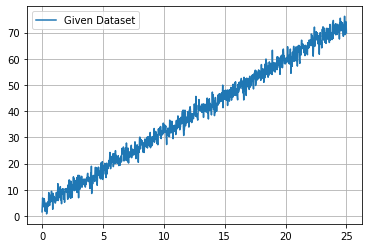

In [3]:
plt.plot(x1,y1,label="Given Dataset")
plt.grid()
plt.legend()

Define the function for a straight line

In [4]:
def st_line(x,m,c):
    return m*x+c

### Using `lstsq`
Get the slope and the y-intercept using lstsq

In [5]:
M=np.column_stack([x1,np.ones(len(x1))])
m1,c1=np.linalg.lstsq(M,y1,rcond=None)[0]
print(f"The estimated equation is y = {m1} x + {c1}")

The estimated equation is y = 2.791124245414918 x + 3.8488001014307436


Now plotting the Estimated Line.

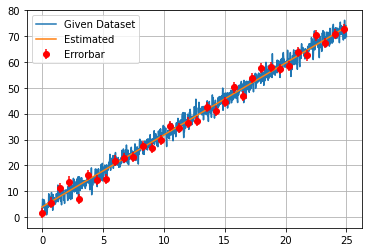

In [6]:
y_estimated1=st_line(x1,m1,c1)
y_error=y1-y_estimated1
plt.plot(x1,y1,label="Given Dataset")
plt.plot(x1,y_estimated1,label="Estimated")
plt.errorbar(x1[::30],y1[::30],np.std(y_error),fmt='ro',label="Errorbar")
plt.legend()
plt.grid()

In [7]:
%timeit np.linalg.lstsq(M,y1,rcond=None)

28.2 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Using `curve_fit` 
We are fitting a Straight Line here.<br>
Get the slope and the y-intercept and finally plot the line.

In [8]:
m1,c1=curve_fit(st_line,x1,y1)[0]
print(f"The estimated equation is y = {m1} x + {c1}")

The estimated equation is y = 2.7911242448201588 x + 3.848800111263445


Plotting the Estimated Line.

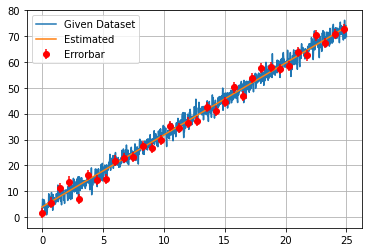

In [9]:
y_estimated1=st_line(x1,m1,c1)
y_error=y1-y_estimated1
plt.plot(x1,y1,label="Given Dataset")
plt.plot(x1,y_estimated1,label="Estimated")
plt.errorbar(x1[::30],y1[::30],np.std(y_error),fmt='ro',label="Errorbar")
plt.legend()
plt.grid()

In [10]:
%timeit curve_fit(st_line,x1,y1)

335 µs ± 68 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


It is clear that `lstsq` works approximately 13 times **faster** than `curve_fit`.<br>
One reason may be that lstsq already knows that the curve we are going to fit is a straight line. 
<br>But for curve_fit we have to explicitly mention the function corresponding to a straight line.

## Dataset 2 - **Fourier Series**
***Problem Statement***<br>
This data corresponds to a sum of several sine waves that are harmonics of some fundamental frequency. You can either use curve_fit to estimate the frequency, or estimate it by examining the data carefully and making your own guesses. After that you need to estimate how many sine waves and what the coefficients are. Explain how you obtained the frequency and the amplitudes, whether linear or non-linear fitting is better, and any other relevant information.

Firstly read from the file and plot the data to get the general idea so that we could use Fourier Transform.

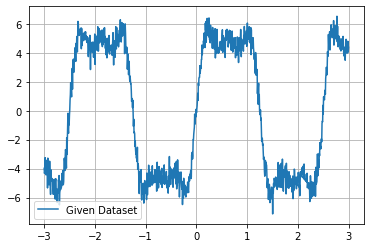

In [11]:
data2=np.loadtxt('dataset2.txt')
x2=data2[:,0]
y2=data2[:,1]

plt.plot(x2,y2,label="Given Dataset")
plt.legend()
plt.grid()

Going to the Frequency Domain using `Fast Fourier Transform`.

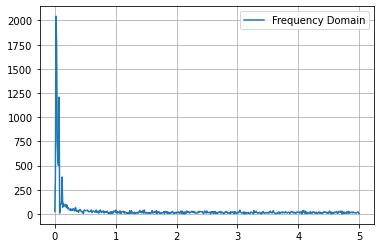

In [12]:
data_points=len(y2)
y22=np.fft.rfft(y2)
y22_abs=np.abs(y22)
x22=rfftfreq(data_points,0.1)

plt.plot(x22,y22_abs,label="Frequency Domain")
plt.legend()
plt.grid()

Remove the Noise in the Frequency Domain. In the above graph we see that the graph has attenuated after some particular frequency.<br> So we will omit the frequencies after a particular threshold.<br> Also we will use only the peak frequencies later on because they have the most dominant contribution (to the Original Signal) in their local bandwidth.

Here I have used the `Amplitude Threshold` as 200. That means any frequency whose Fourier Coefficient (Amplitude) is less than 200 has to be omitted.

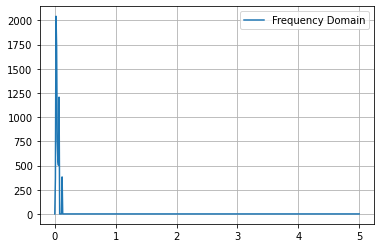

In [13]:
value=200
comparator= (y22_abs>value)
no_noise_y2=comparator*y22_abs

plt.plot(x22,no_noise_y2,label="Frequency Domain")
plt.legend()
plt.grid()

Finding Peaks 

In [14]:
peaks = find_peaks(abs(no_noise_y2))[0]
print(peaks)

[ 2  7 12]


Since we have only 3 peaks that means our Signal will be of the form y=A1 sin(w1\*x) + A2 sin(w2\*x) + A3 sin(w3\*x)<br>
Here we will fit this sum of sine waves into our curve_fit function.

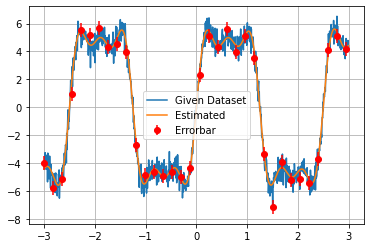

In [15]:
def sine_fxn(x,A1,A2,phase1,A3,A4,phase2,A5,A6,phase3):
    term1=A1*np.sin(peaks[0]*A2*x+phase1)
    term2=A3*np.sin(peaks[1]*A4*x+phase2)
    term3=A5*np.sin(peaks[2]*A6*x+phase3)
    return term1+term2+term3

A1,A2,theta1,A3,A4,theta2,A5,A6,theta3=curve_fit(sine_fxn,x2,y2)[0]
y_estimated2=sine_fxn(x2,A1,A2,theta1,A3,A4,theta2,A5,A6,theta3)

plt.plot(x2,y2,label="Given Dataset")
plt.plot(x2,y_estimated2,label="Estimated")
y_error=y2-y_estimated2
plt.errorbar(x2[::30],y2[::30],np.std(y_error),fmt='ro',label="Errorbar")
plt.legend()
plt.grid()

## Dataset 3 - **Plank's Constant**
***Problem Statement***<br>
The data here corresponds to an observation of Blackbody radiation and follows Planck's law (look it up if you have forgotten the equation). You are told that Boltzmann's constant is 1.38e-23 and the speed of light is 3.0e8 (we assume you know the units). Estimate the temperature at which the observations were taken, and estimate Planck's constant from the data given. Briefly explain your approach.


Read from the file and plot the data. Here we are given Blackbody Radiation Intensity v/s Frequency.<br> Our aim here, is to get a good estimate of the Temperature on which the experiment was performed and to get a precise Estimate of Planck's Constant.

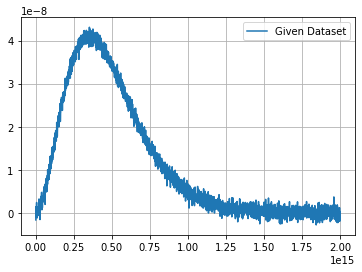

In [16]:
data3=np.loadtxt('dataset3.txt')
x3=data3[:,0]
y3=data3[:,1]

plt.plot(x3,y3,label="Given Dataset")
plt.legend()
plt.grid()

We are already given the values of Speed of Light and the Boltzman Constant. <br>
Also we are defining the Function of Blackbody Radiation Intensity.

In [17]:
c=300000000
k=1.38*(10**(-23))
def intensity(freq,temperature,h):
    return (2*h*(freq**3))/((c**2)*(np.exp(((h*freq)/(k*temperature)))-1))

Estimating the Curve using `curve_fit` using a non-linear function to get the **Temperature** and The **Planks Constant**.<br> Also I know that the Temperature will be of the order of 10^3 and the PLanks Constant will be of the Order 10^-34.<br> This initialization is done so that we get the values of *Temperature* and *h* correctly.

 Estimated Temperature = 6011.361522009629 
 Estimated Plank's Constant = 6.6432297594040026e-34


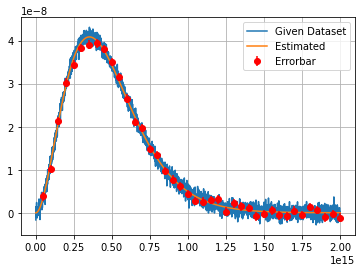

In [18]:
temperature,h=curve_fit(intensity,x3,y3,p0=(10**3,(10**-34)))[0]
print(f" Estimated Temperature = {temperature} \n Estimated Plank's Constant = {h}")

y_estimated3=intensity(x3,temperature,h)
y_error=y3-y_estimated3
plt.plot(x3,y3,label="Given Dataset")
plt.plot(x3,y_estimated3,label="Estimated")
plt.errorbar(x3[::75],y3[::75],np.std(y_error),fmt='ro',label="Errorbar")
plt.legend()
plt.grid()

## Dataset 4 - **Unknown Data**
***Problem Statement***<br>
This is a dataset where there are multiple measurements for each point on the x-axis. The nature of the data is unknown - even the TAs have not been informed of how the data was generated. You need to decide on what is the best fit, extract suitable fit parameters, and justify your choices.

Reading from the file.


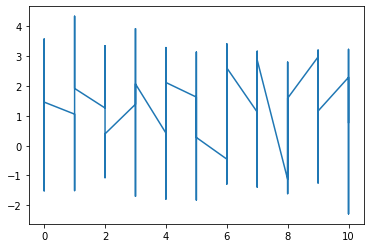

In [19]:
data4=np.loadtxt('dataset4.txt')
x4=data4[:,0]
y4=data4[:,1]

plt.plot(x4,y4)

The above plot looks Ambigious. So I will try a different approach.<br> Let's see what is the Scatter Plot of the data to get a better insight.

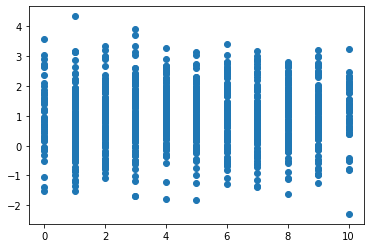

In [20]:
plt.scatter(x4,y4)

From the scatter plot it is clear that For every x we have many values of y. <br>
I need to estimate the value of y for each x.<br> 
This can be done by taking mean of all the y for the corresponding x.

In [21]:
data=[[] for i in range(11)]
for i in range(len(y4)):
    data[int(x4[i])].append(float(y4[i]))
avg=[]
for i in range(0,11):
    avg.append(np.mean(np.array(data[i])))


Now after we have obtained the averages we plot it.

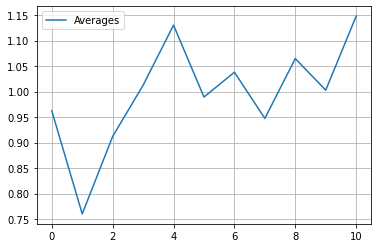

In [22]:
plt.plot(range(0,11),avg,label="Averages")
plt.grid()
plt.legend()

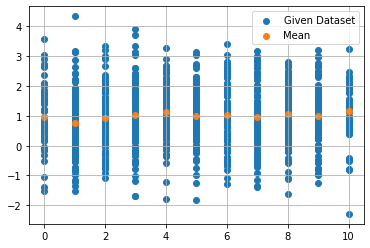

In [23]:
plt.scatter(x4,y4,label="Given Dataset")
plt.scatter(range(0,11),avg,label="Mean")
plt.grid()
plt.legend()

In my opinion this dataset is taken from an experiment where for every x we have a particular value of y.<br>
In that experiment we obtained many y-values. So to get the correct reading of y, I took the mean. <br>I could also have taken Median or Mode, but in my opinion Mean is a better parameter.<br> If the original scatter plot of the data was more scattered away then Median would have been better parameter.<br>Here, since it is not much scattered so I think Mean would work just fine. 